In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import igl
import numpy as np
import scipy as sp
from meshplot import plot, subplot, interact
from scipy.sparse.linalg import spsolve
import meshplot
import os
import math
import meshzoo
import skimage
from skimage import measure

In [2]:
def tubeGen(L,R):
    points, cells= meshzoo.tube(length = L, radius = R, n = 100)

    v = points

    f1_id = []
    f2_id = []

    color = []


    for i in range(len(v)):
        if v[i][2] > 0.95*L/2:
            color += [2]
            f1_id += [i]
        else:
            if v[i][2] < -0.95*L/2:
                color += [-2]
                f2_id += [i]
            else:
                color += [0]
    return [v,f1_id,f2_id,points,cells,color]


In [18]:
def tetraTube(L,R):
    tubes = []
    for i in range(12):
        points, cells= meshzoo.tube(length = L, radius = R, n = 30)
        tubes.append([points,cells])
    spheres = []
    for i in range(8):
        points, cells = meshzoo.uv_sphere(num_points_per_circle=30, num_circles=50, radius=R)
        spheres.append([points,cells])
    #rotate tubes
    for i in range(4,8):
        for j in range(len(tubes[i][0])):
            tubes[i][0][j] = np.array([[1,0,0],[0,0,-1],[0,1,0]]) @ tubes[i][0][j]
    for i in range(8,12):
        for j in range(len(tubes[i][0])):
            tubes[i][0][j] = np.array([[0,0,1],[0,1,0],[-1,0,0]]) @ tubes[i][0][j]
    #move spheres
    dirx = [L/2, L/2, L/2, L/2, -L/2, -L/2, -L/2, -L/2]
    diry = [L/2, L/2, -L/2, -L/2, L/2, L/2, -L/2, -L/2]
    dirz = [L/2, -L/2, L/2, -L/2, L/2, -L/2, L/2, -L/2]
    for i in range(8):
        for j in range(len(spheres[i][0])):
            spheres[i][0][j][0] += dirx[i]
            spheres[i][0][j][1] += diry[i]
            spheres[i][0][j][2] += dirz[i]
    #move tubes
    dirx = [L/2, -L/2, L/2, -L/2, L/2, L/2, -L/2, -L/2, 0, 0, 0, 0]
    diry = [L/2, L/2, -L/2, -L/2, 0, 0, 0, 0, L/2, L/2, -L/2, -L/2]
    dirz = [0, 0, 0, 0, L/2, -L/2, L/2, -L/2, L/2, -L/2, L/2, -L/2]
    for i in range(12):
        for j in range(len(tubes[i][0])):
            tubes[i][0][j][0] += dirx[i]
            tubes[i][0][j][1] += diry[i]
            tubes[i][0][j][2] += dirz[i]
    #combine tubes and spheres
    totalPoints = []
    totalCells = []
    curr = len(tubes[0][0])
    for i in range(1,len(tubes)):
        for j in range(len(tubes[i][1])):
            tubes[i][1][j] += curr
        curr += len(tubes[i-1][0])
    for i in range(len(spheres)):
        for j in range(len(spheres[i][1])):
            spheres[i][1][j] += curr
        curr += len(spheres[i-1][0])
    for i in range(len(tubes)):
        for j in range(len(tubes[i][0])):
            totalPoints.append(tubes[i][0][j])
        for j in range(len(tubes[i][1])):
            totalCells.append(tubes[i][1][j])
    for i in range(len(spheres)):
        for j in range(len(spheres[i][0])):
            totalPoints.append(spheres[i][0][j])
        for j in range(len(spheres[i][1])):
            totalCells.append(spheres[i][1][j])
    #fixed points
    f1_id=[]
    f2_id=[]
    dirx = [L/2, L/2, L/2, L/2, -L/2, -L/2, -L/2, -L/2]
    diry = [L/2, L/2, -L/2, -L/2, L/2, L/2, -L/2, -L/2]
    dirz = [L/2, -L/2, L/2, -L/2, L/2, -L/2, L/2, -L/2]
    for i in range(len(totalPoints)):
        for j in range(8):
            if math.sqrt((totalPoints[i][0]-dirx[j])**2+(totalPoints[i][1]-diry[j])**2+(totalPoints[i][2]-dirz[j])**2)<=R*1.01 and dirz[j]>0:
                f1_id+=[i]
                break
            elif math.sqrt((totalPoints[i][0]-dirx[j])**2+(totalPoints[i][1]-diry[j])**2+(totalPoints[i][2]-dirz[j])**2)<=R*1.01 and dirz[j]<0:
                f2_id+=[i]
                break
    return np.asarray(totalPoints), np.asarray(totalCells), np.asarray(f1_id), np.asarray(f2_id)


In [64]:
totalPoints, totalCells = tetraTube(1,2)
totalCells[2000]

array([1142, 1151, 1143])

C:\Users\72882\AppData\Local\Temp\ipykernel_5592\2803734279.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


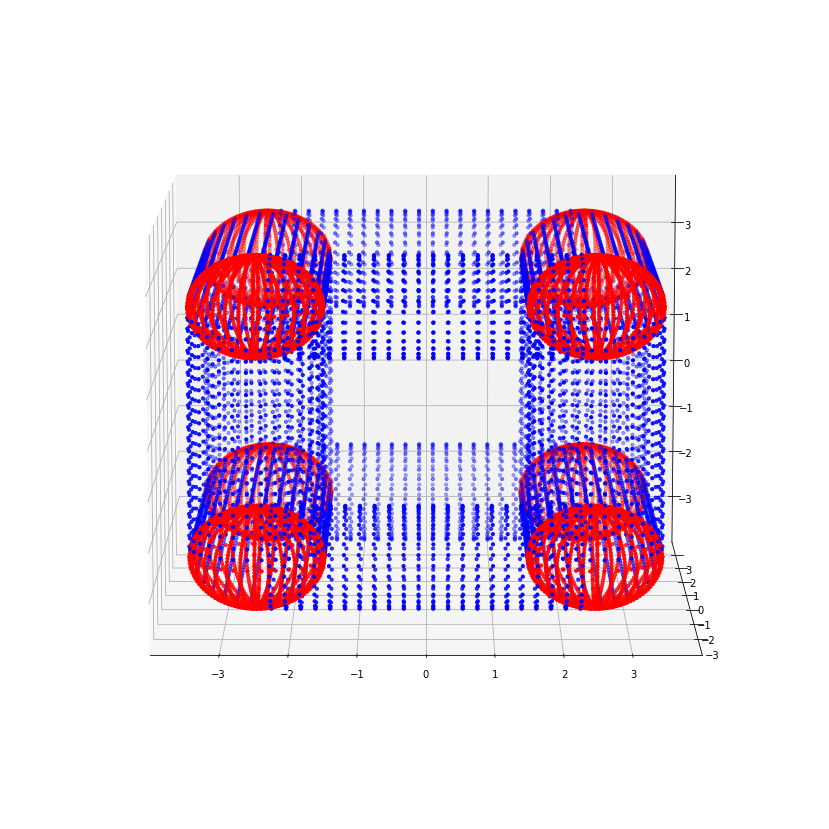

In [19]:
def show(L,R):
    points, cells, f1, f2 = tetraTube(L,R)
    color = []
    for i in range(len(points)):
        if i in f1:
            color += ['red']
        elif i in f2:
            color += ['red']
        else:
            color += ['blue']
    p = subplot(points, cells, shading={"wireframe": False}, s=[1,4,0])
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')
    ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], c=color, s = 10 , cmap='hsv')

    ax.view_init(10,-90)
show(5,1)

C:\Users\72882\AppData\Local\Temp\ipykernel_9148\3876793318.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


3000


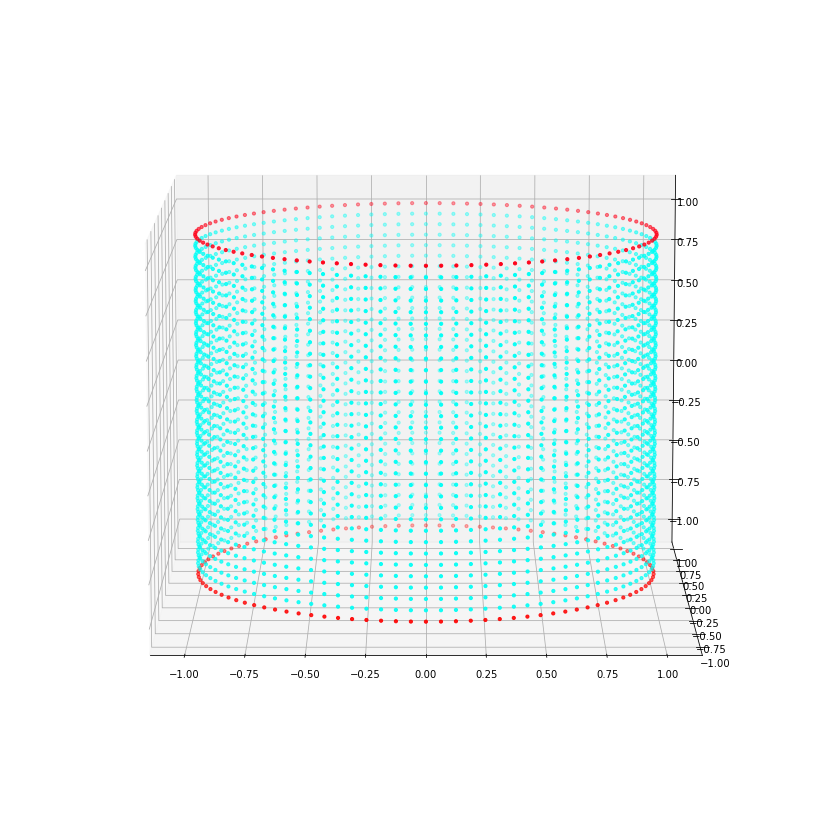

In [5]:
def show(L,R):
    v, f1_id, f2_id, points, cells, color = tubeGen(L,R)
    p = subplot(points, cells, shading={"wireframe": False}, s=[1,4,0])
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')
    ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], s = 10 , c=color, cmap='hsv')

    ax.view_init(10,-90)
    freePoint = len(v)-len(f1_id)-len(f2_id)
    print(freePoint)
show(2,1)

In [3]:
def miniQ(l,v,f1,f2):
    lt = np.transpose(l)
    boundV = []
    boundLt = []
    nonBoundLt = []
    nonBoundL2 = []
    for i in range(v.shape[0]):
        if i in f1 or i in f2:
            boundV.append(v[i])
            boundLt.append(lt[i])
        else:
            nonBoundLt.append(lt[i])

    boundL = np.transpose(boundLt)
    nonBoundL = np.transpose(nonBoundLt)

    for i in range(v.shape[0]):
        if i not in f1 and i not in f2:
            nonBoundL2.append(nonBoundL[i])
    b = -boundL.dot(boundV)
    b2 = []
    for i in range(v.shape[0]):
        if i not in f1 and i not in f2:
            b2.append(b[i])
    x = spsolve(nonBoundL2, b2)
    final = []
    temp = 0
    for i in range(v.shape[0]):
        if i in f1 or i in f2:
            final.append(v[i])
        else:
            final.append(x[temp])
            temp+=1
    return np.asarray(final)

In [5]:
def minimization(L,R):
    v, f1_id, f2_id, colors, cells = tubeGen(L,R)

    vs = [v]
    es = []

    l = -1/8*igl.cotmatrix(vs[0],cells)
    vt = np.transpose(vs[0])
    es.append(vt.dot(l.dot(vs[0])).trace())

    for i in range(100):
        l = -1/8*igl.cotmatrix(vs[i],cells).toarray()

        Q = miniQ(l,vs[i],f1_id,f2_id)
        vs.append(Q)

        # energy 
        vt = np.transpose(vs[i+1])
        if(math.isnan(vt.dot(l.dot(vs[i+1])).trace())): break
        es.append(vt.dot(l.dot(vs[i+1])).trace())
    es=[ i for i in es if not(math.isnan(i)==True)]
    return [vs, cells, es]


In [16]:
def minimizationTetra(L,R):
    v, cells, f1_id, f2_id = tetraTube(L,R)

    vs = [v]
    es = []

    l = -1/8*igl.cotmatrix(vs[0],cells)
    vt = np.transpose(vs[0])
    es.append(vt.dot(l.dot(vs[0])).trace())

    for i in range(100):
        l = -1/8*igl.cotmatrix(vs[i],cells).toarray()

        Q = miniQ(l,vs[i],f1_id,f2_id)
        vs.append(Q)

        # energy 
        vt = np.transpose(vs[i+1])
        if(math.isnan(vt.dot(l.dot(vs[i+1])).trace())): break
        es.append(vt.dot(l.dot(vs[i+1])).trace())
    es=[ i for i in es if not(math.isnan(i)==True)]
    return [vs, cells, es]


In [20]:
vs,cells,es = minimizationTetra(1,0.2)

c:\Users\72882\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Users\72882\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [30]:
def move(points, distance):
    for i in range(len(points)):
        points[i][0]+=distance[0]
        points[i][1]+=distance[1]
        points[i][2]+=distance[2]
    return points

In [10]:
vs,cells,es = minimization(10,1)
points1, cells1 = meshzoo.uv_sphere(num_points_per_circle=100, num_circles=60, radius=1)
points2, cells2 = meshzoo.uv_sphere(num_points_per_circle=100, num_circles=60, radius=1)
points1 = move(points1,[0,0,10/2])
points2 = move(points2,[0,0,-10/2])
totalPoints = []
totalCells = []
for points3 in vs:
    totalPoints.append(np.vstack((points1,points2,points3)))

totalCells = np.vstack((cells1,cells2,cells))

for i in range(len(cells1),len(totalCells)):
    if i<len(cells1)+len(cells2):
        totalCells[i][0]+=len(points1)
        totalCells[i][1]+=len(points1)
        totalCells[i][2]+=len(points1)
    else:
        totalCells[i][0]+=len(points1)+len(points2)
        totalCells[i][1]+=len(points1)+len(points2)
        totalCells[i][2]+=len(points1)+len(points2)

KeyboardInterrupt: 

In [21]:
p = subplot(totalPoints[0], cells, shading={"wireframe": False}, s=[1,4,0])
p = subplot(totalPoints[1], cells, shading={"wireframe": False}, s=[1,4,1],data=p)
p = subplot(totalPoints[2], cells, shading={"wireframe": False}, s=[1,4,2],data=p)

NameError: name 'totalPoints' is not defined

In [22]:
p = subplot(vs[0], totalCells, shading={"wireframe": False}, s=[1,4,0])
p = subplot(vs[1], totalCells, shading={"wireframe": False}, s=[1,4,1],data=p)
p = subplot(vs[2], totalCells, shading={"wireframe": False}, s=[1,4,2],data=p)

NameError: name 'totalCells' is not defined

In [25]:
def area(r):
    return math.pi * (r)**2

R=1
x = [1.1,1.15,1.2,1.25,1.26,1.27,1.28,1.29,1.3,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.4,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48]

convV = []
convC = []
for i in x:
    vs,cells,es = minimization(i,R)
    es=[ i for i in es if not(math.isnan(i)==True)]
    lastidx = len(es)-1
    convV.append(vs[lastidx])
    convC.append(cells)

c:\Users\72882\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Users\72882\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [26]:
convA = []
for i in range(len(convV)):
    area = skimage.measure.mesh_surface_area(convV[i],convC[i])
    convA.append(area)

convA

[6.51163397770727,
 6.760402575549692,
 6.999688784370818,
 7.227527084768899,
 7.271467673225743,
 7.314755792044409,
 7.357329784538516,
 7.398876665466364,
 7.439736574970827,
 7.479511372369853,
 7.517860221095083,
 6.279117667055914,
 6.279281261516325,
 6.279209245929685,
 6.279365261928759,
 6.279336405103434,
 6.279062370539799,
 6.281670193347281,
 6.279055715767583,
 6.36758448291646,
 6.279097407921981,
 6.279092013310152,
 6.27910399857732,
 6.279056064454594,
 6.279061808461662,
 6.279082317768285,
 6.279156935964564]

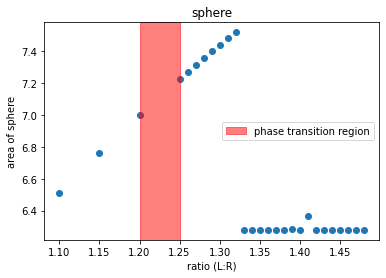

In [28]:
fig, ax = plt.subplots()
ax.scatter(x,convA)
ax.axvspan(x[2], x[3], alpha=0.5, color='red', label = "phase transition region")
ax.set_title("sphere")

plt.axis('on')
plt.ylabel("area of sphere")
plt.xlabel("ratio (L:R)")
plt.legend()
#plt.savefig('tube')


In [63]:
a = []
points, cells= meshzoo.tube(length = 1, radius = 2, n = 100)
points2, cells2= meshzoo.tube(length = 1, radius = 1, n = 100)
a.append(points[1])
a.append(points2[2])
len(points)



800

In [24]:
p = subplot(vs[0], cells, shading={"wireframe": False}, s=[1,4,0])
p = subplot(vs[1], cells, shading={"wireframe": False}, s=[1,4,1],data=p)
p = subplot(vs[3], cells, shading={"wireframe": False}, s=[1,4,2],data=p)

In [ ]:
R = a * math.cosh(L/(2*a))